# To test the bias evolution models

In [1]:
#Create a file to list all the parameters of cosmology in Abacus simulation
from __future__ import print_function

#####importing the necessary libraries
#To make the plots inline otherwise it will make seperate figure
%matplotlib inline 
#for high resolution plot outputs
%config InlineBackend.figure_format = 'retina'

import numpy as np

import os
import sys

#latex display
from IPython.display import Latex

import fitsio as F

####plottinng library and setting
import pylab as pl
import matplotlib
matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})
wdir='../jnk/'


from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(ticks=True, grid=False, figsize=(10, 8))

# reset default matplotlib rcParams
jtplot.reset()

In [2]:
# Load the module for wtheta fits
sys.path=['../examples/biaswtheta/']+sys.path
sys.path=['../']+sys.path
import wtheta_bias as module_wth
import mcmc_utility as mcutil

In [3]:
#load the configuration file
#config_file='../examples/biaswtheta/bias_evol.yaml'
config_file='../examples/biaswtheta/bias_evol_BGS.yaml'

cfg=mcutil.init_config_yaml(inifile=config_file)

*****Using parameters *****
bz_0
bz_1
bz_2
bz_3
**** ndim= 4 ****
Setting: save_model = False
Setting: bfit = False
Setting: nthreads = 8


In [6]:
cfg['fit_theta_lim']=[1e-3,1e0]

In [7]:
#load the data files
data_dic=module_wth.Load_data(cfg,like_name='like_name')

*** Following redshift bins are uses ***
 bin=0 , zmax_pz=0.133 
 bin=1 , zmax_pz=0.263 
 bin=2 , zmax_pz=0.335 
 bin=3 , zmax_pz=0.424 
0 zmax_pz (4,)
1 tomo_v0_0 (30, 344)
2 tomo_v0_1 (30, 344)
3 tomo_v0_2 (30, 344)
4 tomo_v0_3 (30, 344)
6 theta_deg (26,)
7 theta_rad (26,)
8 wtheta_mu (104,)
9 cov (104, 104)
10 icov (104, 104)
11 nz_mat (99, 5)
Note: redshifts have been re-sorted (earliest first)


In [6]:
print(data_dic.keys())

dict_keys(['zmax_pz', 'tomo_v0_0', 'tomo_v0_1', 'tomo_v0_2', 'tomo_v0_3', 'njn', 'theta_deg', 'theta_rad', 'wtheta_mu', 'cov', 'icov', 'nz_mat', 'omth', 'Theory'])


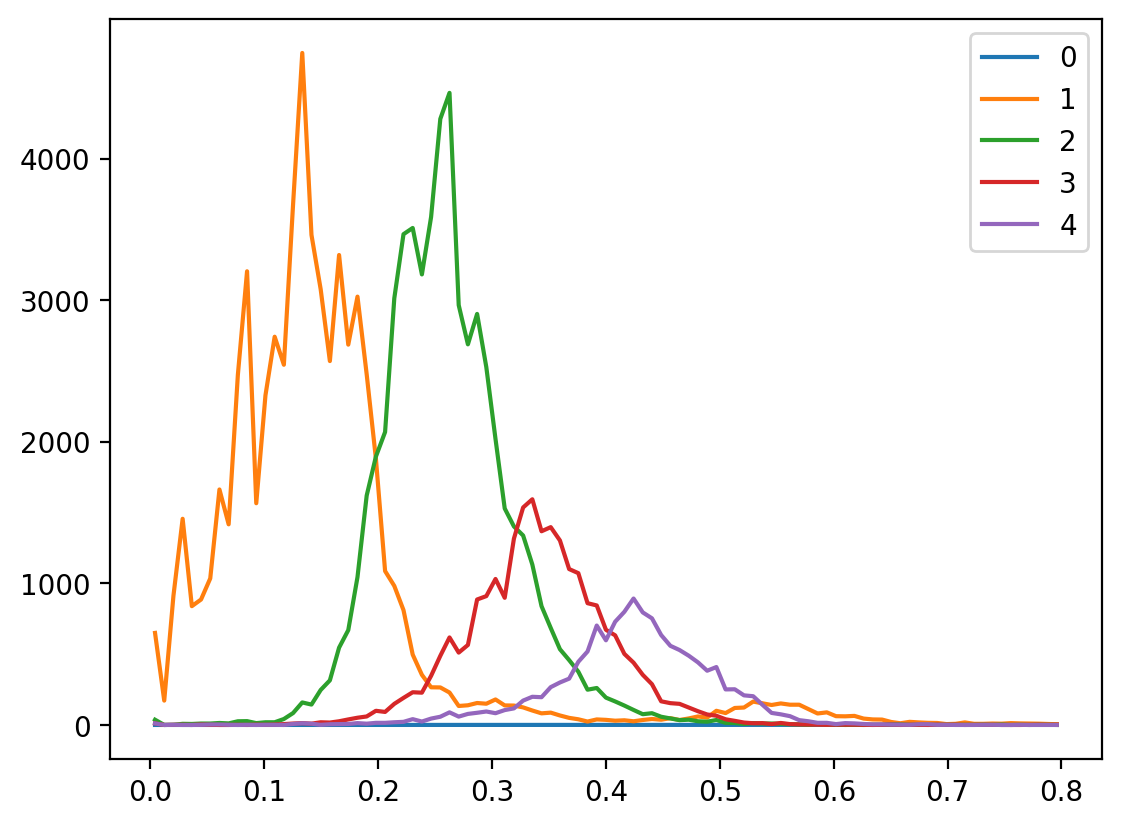

In [7]:
for ii in range(0,data_dic['nz_mat'].shape[1]):
    pl.plot(data_dic['nz_mat'][:,0],data_dic['nz_mat'][:,ii],label=str(ii))
pl.legend()
pl.show()

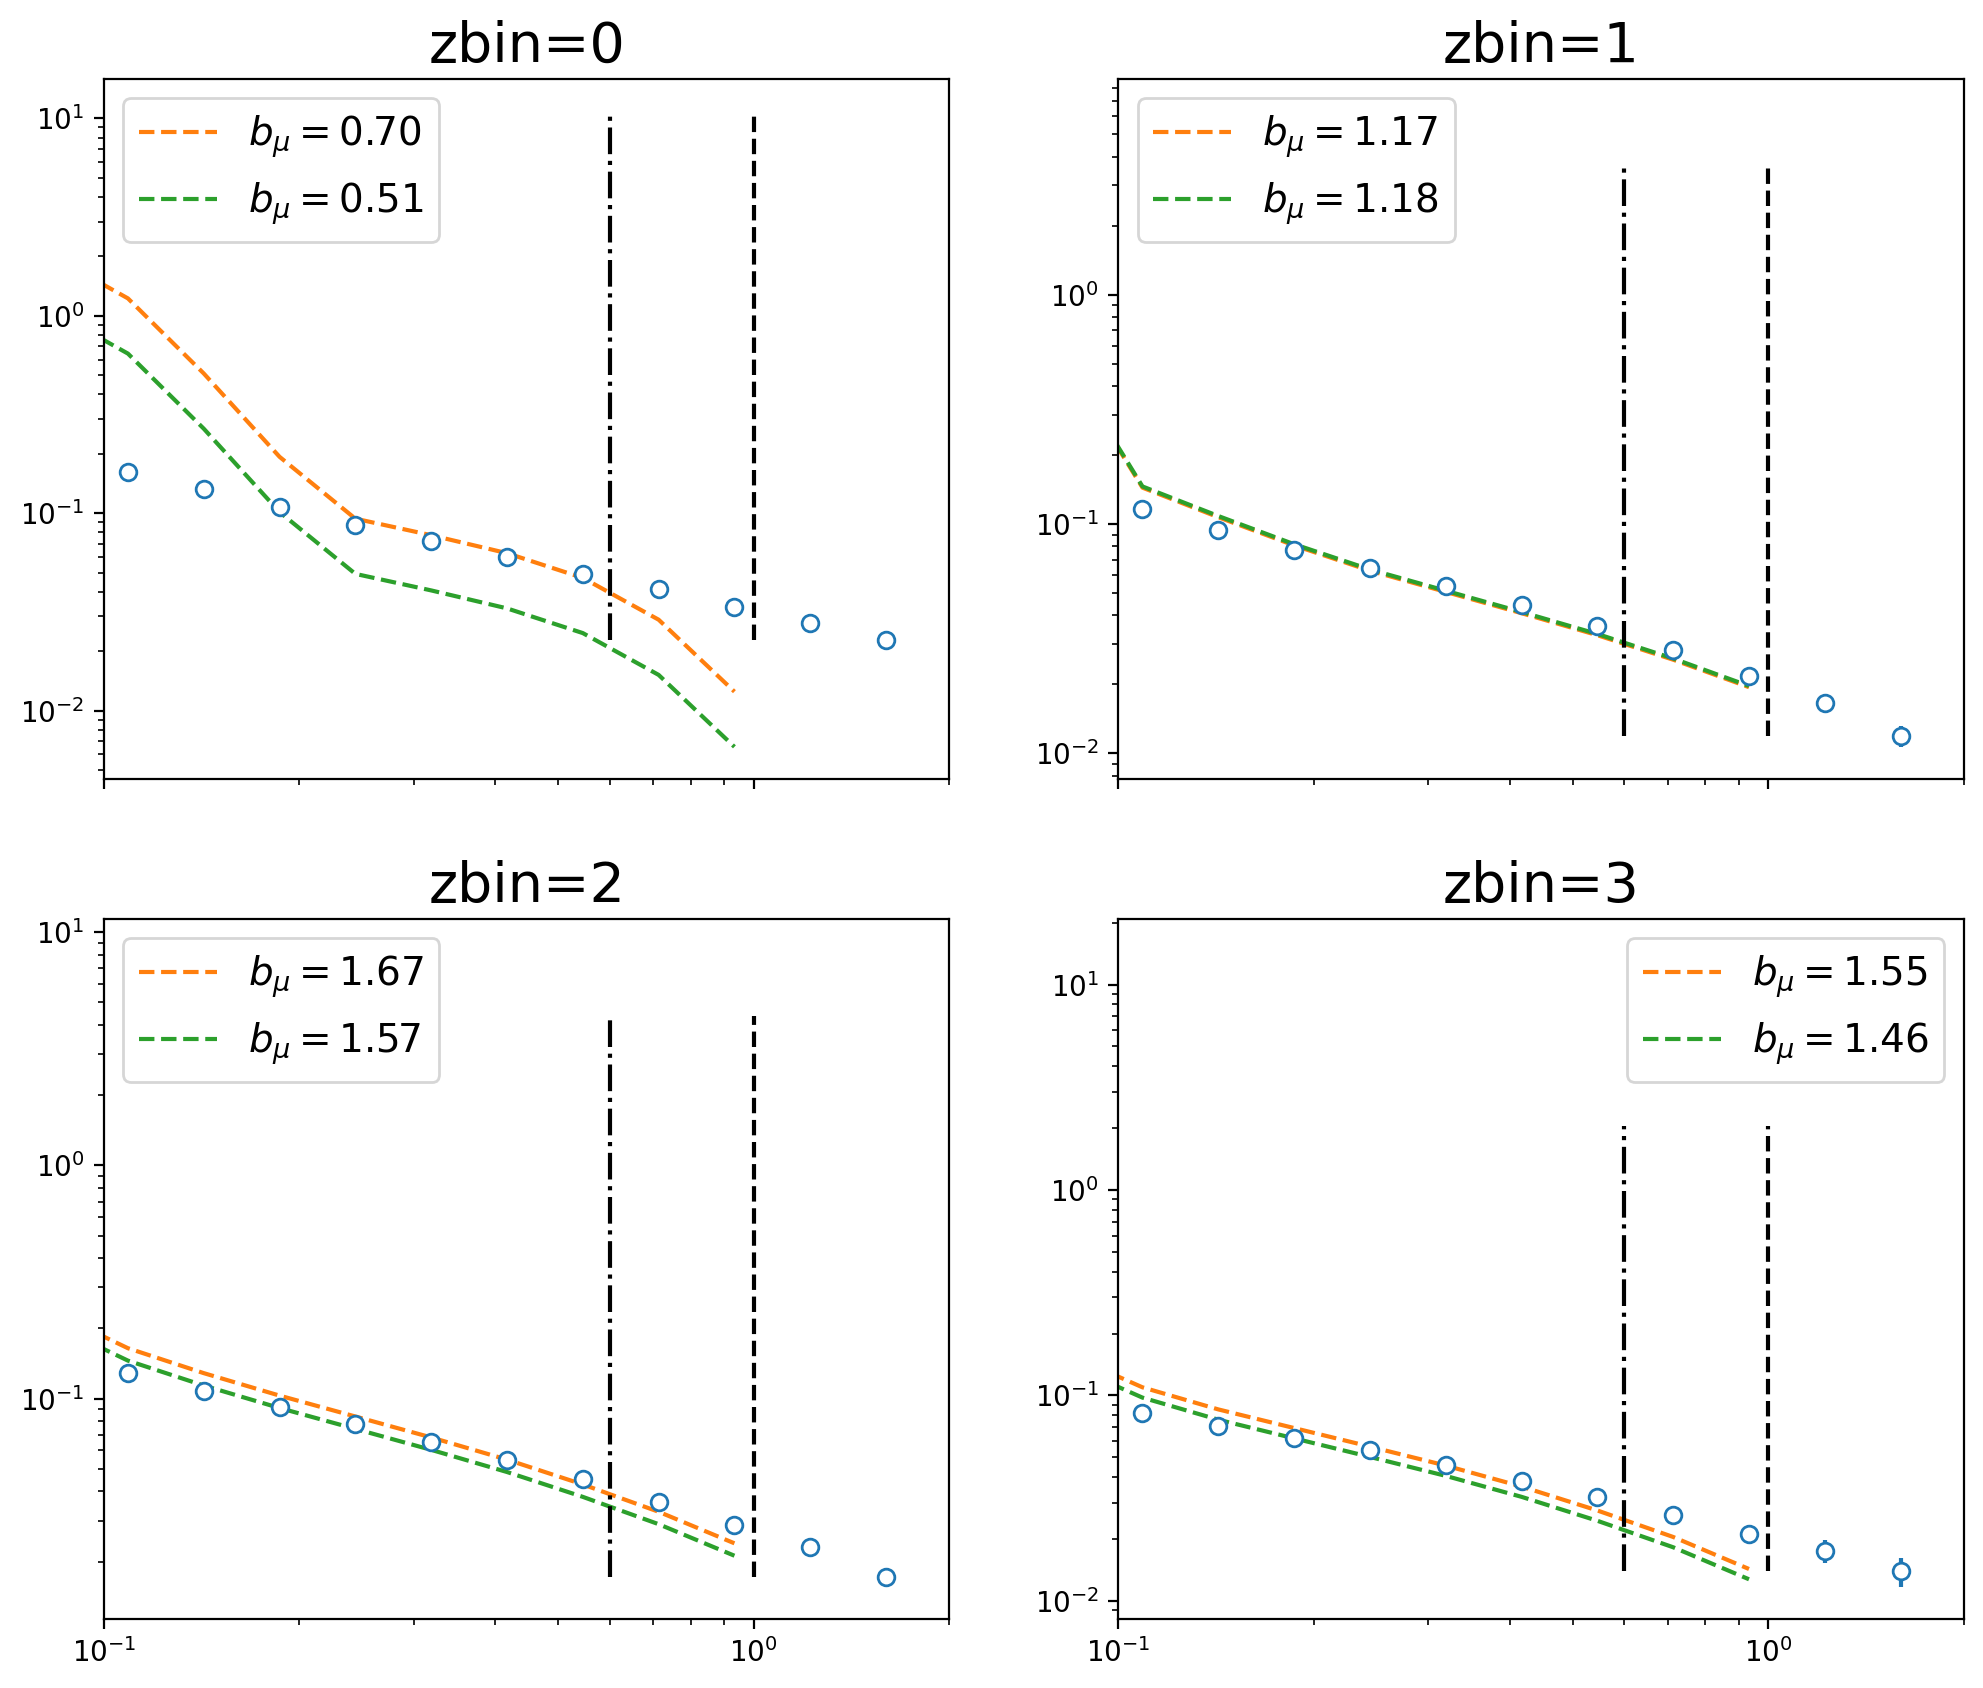

In [26]:
def plot_data_model(data_dic,zbin=0,bzmodel='slinear',xlim=None,axin=None):
    if(axin is not None):
        pl.sca(axin)
        
    wth_data=data_dic['tomo_v0_%d'%zbin]
    
    pl.errorbar(wth_data[:,0]*180.0/np.pi,wth_data[:,1],yerr=wth_data[:,2],fmt='o',mfc='w')
    
    nz_mat=data_dic['nz_mat']
    
    
    if(False):
        #blinz=1.7
        #bz0=0.77;bz1=1.65;bz2=0; #linear fit
        #bz0=0.81;bz1=2.8;bz2=-1.5 #quadratic fit
        #bz0=0.46;bz1=3.74;bz2=-2.0 #quadratic fit NDECALS
        #bz0=0.53;bz1=3.54;bz2=-1.87 #quadratic fit NBMZLS
        bz0=0.27;bz1=4.99;bz2=-4.99 #BGS trial
        blinz=module_wth.bias_model(nz_mat[:,0],bz0,bz1,bz2,bzmodel='quadratic')
    else:
        localDic=cfg['LD'].copy() #copy the halo population stuff
        #localDic[tmp['name']]=tmp[tmp['name']]
        localDic=mcutil.map_param(bestfit,cfg,localDic)
        blinz_bfit=module_wth.bias_model(nz_mat[:,0],localDic,cfg,data_dic,bzmodel=bzmodel,zbin=zbin)
        
        localDic=mcutil.map_param(bestfit_new,cfg,localDic)
        blinz_bfit_new=module_wth.bias_model(nz_mat[:,0],localDic,cfg,data_dic,bzmodel=bzmodel,zbin=zbin)

        
    for blinz in [blinz_bfit_new,blinz_bfit]:
        wth_theory=data_dic['Theory'](np.column_stack([nz_mat[:,0],nz_mat[:,zbin+1]]),blinz,validate_input=False)
        mu_bias=np.sum(blinz[:,1]*nz_mat[:,zbin+1])/np.sum(nz_mat[:,zbin+1])
        pl.plot(wth_theory[:,0]*180.0/np.pi,wth_theory[:,1],'--',label=r'$b_{\mu}=%4.2f$'%(mu_bias,))
    

        
    #plot xlim
    if(xlim is not None):
        pl.plot([xlim[0],xlim[0]],[wth_data[:,1].min(),wth_data[:,1].max()],'k-.')
        pl.plot([xlim[1],xlim[1]],[wth_data[:,1].min(),wth_data[:,1].max()],'k--')
        
    pl.xlim([1e-1,2])
    pl.xscale('log')
    pl.yscale('log')
    pl.title('zbin=%d'%zbin,fontsize=20)
    pl.legend(fontsize=14)
    
    
nzbin=4;
nrow=2;ncol=2
fig,axarr=pl.subplots(nrow,ncol,sharex=True,sharey=False,figsize=(6*ncol,nrow*5))
axarr=axarr.reshape(axarr.size)

bestfit_new=np.array([0.7,1.17,1.67,1.55])

for zbin in range(0,nzbin):
    plot_data_model(data_dic,zbin=zbin,bzmodel=bzmodel,xlim=[0.6,1.0],axin=axarr[zbin])
    
pl.savefig('plots/BGS_wtheta_NBMZLS.png')
pl.show()

In [19]:
bestfit

array([0.7       , 1.17118938, 1.57683661, 1.4942712 ])

loaded: bevolution_BGS_ANY_NDECALS_EdWsysv0_29Apr2021v1_quadraticthetalim_0.6_1.0_emcee.txt
burnin:  40000
bestfit:  [  1.         -43.8929175    0.77575926   1.27978374   1.57318156
   1.5285451    0.        ]
loaded: bevolution_BGS_ANY_NDECALS_EdWsysv0_29Apr2021v1_binnedthetalim_0.6_1.0_emcee.txt
burnin:  40000
bestfit:  [  1.         -61.3732462    0.5112584    1.17802865   1.56754586
   1.48797409   0.        ]


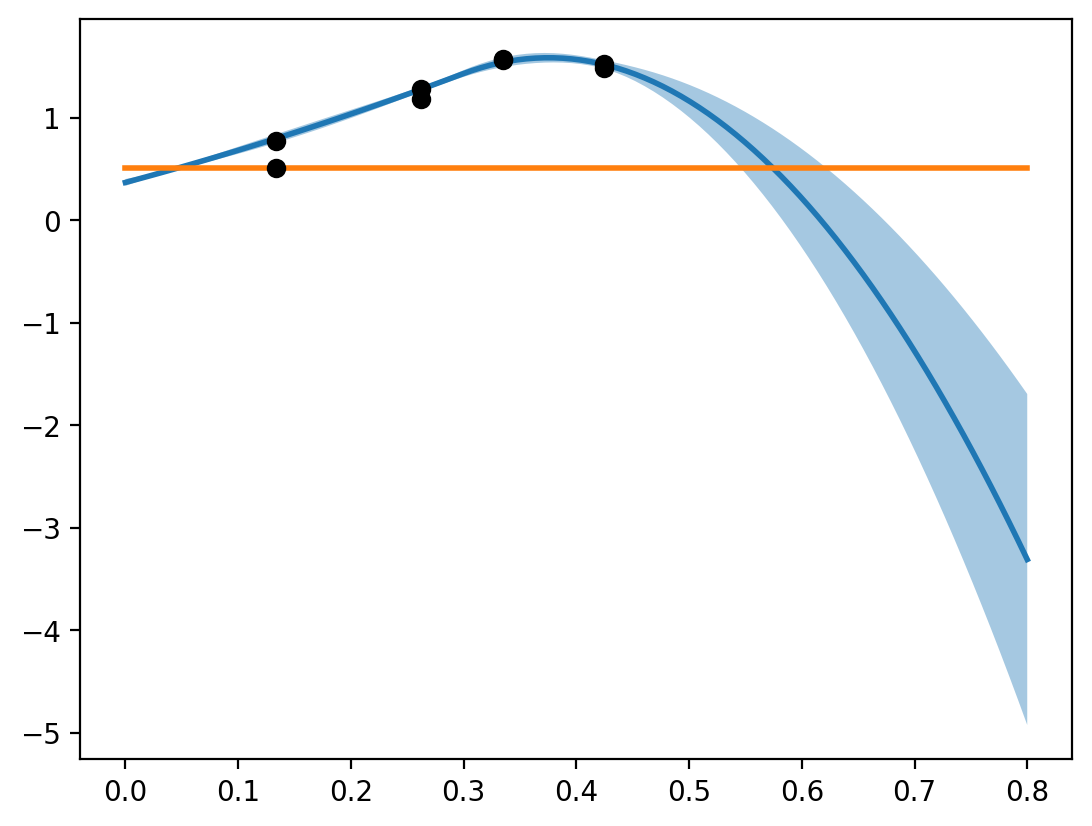

In [49]:
def get_chain_key(tracer,sky,bzmodel='slinear',fit_theta_lim= [0.6,1.0]):
    chain_key='%s-%s-%s-thlim-%s-%s'%(tracer,sky,bzmodel,str(fit_theta_lim[0]),str(fit_theta_lim[1]))
    return chain_key

def load_chain(tracer,sky,bzmodel='slinear',fit_theta_lim= [0.6,1.0],chain_dic={},reload=False):
    
    ckey=get_chain_key(tracer,sky,bzmodel=bzmodel,fit_theta_lim=fit_theta_lim)
    if(ckey in chain_dic.keys() and reload==False):
        print('Already loaded: %s'%ckey)
        return chain_dic    
    
    chain_dir='/Users/shock/Documents/Projects/EASYmcmc/chains_bwtheta/'
    chain_file='bevolution_%s_%s_EdWsysv0_29Apr2021v1_%sthetalim_%s_%s_emcee.txt'%(tracer,sky,bzmodel,
                                                                str(fit_theta_lim[0]),str(fit_theta_lim[1]))
    tchain=np.loadtxt(chain_dir+chain_file)
    burnin=np.int(0.5*tchain.shape[0])
    tchain=tchain[burnin:,:]
    
    chain_dic[ckey]=tchain
    
    print('loaded: %s'%chain_file)
    print('burnin: ',burnin)
    
    #get the best fit result
    
    return chain_dic


def plot_bias_model(zarr,tracer,sky,bzmodel='slinear',fit_theta_lim=[],chain_dic={},bz_dic={},reload=True,colin=None):
    
    #load chain
    chain_dic=load_chain(tracer,sky,bzmodel=bzmodel,fit_theta_lim=fit_theta_lim,chain_dic=chain_dic,reload=reload)
    
    #subsample chain
    ckey=get_chain_key(tracer,sky,bzmodel=bzmodel,fit_theta_lim=fit_theta_lim)
    tchain=chain_dic[ckey]
    tchain_sub=tchain[-50:,:]
    
    #evaluate bias
    if(ckey not in bz_dic.keys() or reload==True):
        nsamp=tchain_sub.shape[0]
        bz_arr=np.zeros((zarr.size,nsamp))
        for ii in range(0,nsamp):
            localDic=cfg['LD'].copy() #copy the halo population stuff
            #localDic[tmp['name']]=tmp[tmp['name']]
            localDic=mcutil.map_param(tchain_sub[ii,2:-1],cfg,localDic)
            bz_this=module_wth.bias_model(zarr,localDic,cfg,data_dic,bzmodel=bzmodel,zbin=0)
            bz_arr[:,ii]=bz_this[:,1]
            
        
        bz_res=np.column_stack([zarr,bz_arr.mean(axis=1),np.std(bz_arr,axis=1)])
        bz_dic[ckey]=np.column_stack([bz_res,bz_arr])

    bz_res=bz_dic[ckey][:,:3]
    
    pl.fill_between(bz_res[:,0],bz_res[:,1]-bz_res[:,2],bz_res[:,1]+bz_res[:,2],color=colin,alpha=0.4)
    pl.plot(bz_res[:,0],bz_res[:,1],color=colin,lw=2,label=ckey)
    
    #find the best fit
    indmin=np.argmax(tchain_sub[:,1])
    print('bestfit: ',tchain_sub[indmin,:])
    pl.plot(data_dic['zmax_pz'],tchain_sub[indmin,2:-1],'ko')
    
    return chain_dic,bz_dic,tchain_sub[indmin,2:-1]
    
#tracer='LRG'
tracer='BGS_ANY'
sky='NDECALS'
#sky='NBMZLS'

chain_dic={}
bz_dic={}
zarr=np.linspace(0,0.8,100)
#bzmodel='slinear'
#bzmodel='quadratic'
bzmodel='binned'
for bzmodel in ['quadratic','binned']:
    chain_dic,bz_dic,bestfit=plot_bias_model(zarr,tracer,sky,bzmodel=bzmodel,fit_theta_lim= [0.6,1.0],
                                         chain_dic=chain_dic,bz_dic=bz_dic,reload=True,colin=None)

pl.show()

In [48]:
import numpy as np

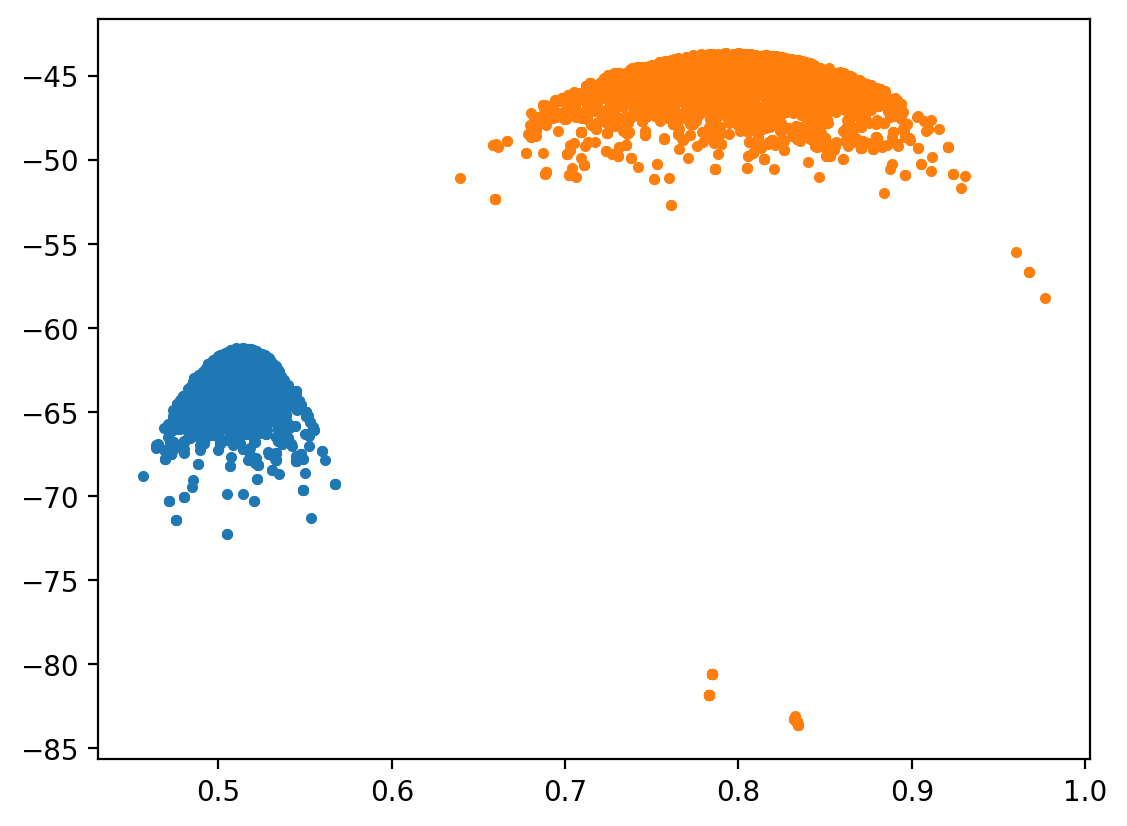

In [54]:
tc1=chain_dic['BGS_ANY-NDECALS-binned-thlim-0.6-1.0']
tc2=chain_dic['BGS_ANY-NDECALS-quadratic-thlim-0.6-1.0']
npt=5000
for tc in [tc1,tc2]:
    pl.plot(tc[-npt:,2],tc[-npt:,1],'.')

pl.show()

0 63562.0
1 57593.0
2 23802.0
3 13620.0


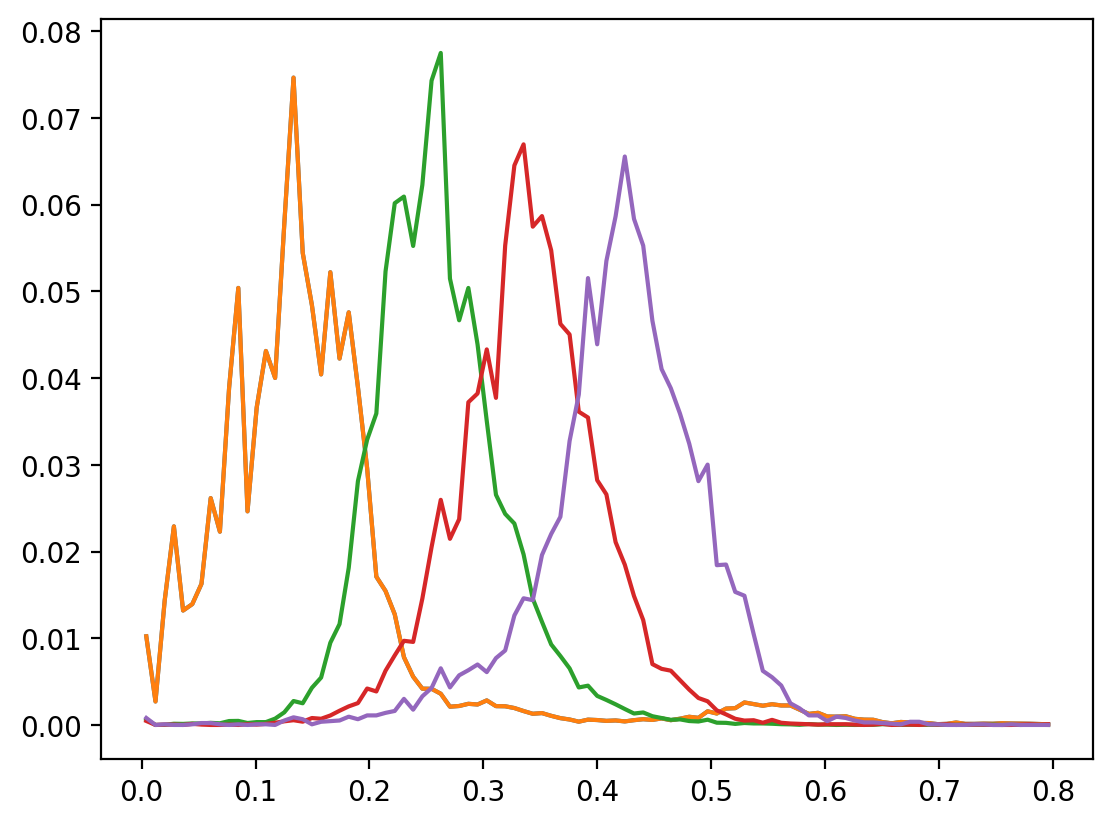

In [39]:
#pl.plot(blinz[:,0],blinz[:,1])#blinz
for zbin in range(0,nzbin):
    pl.plot(nz_mat[:,0],nz_mat[:,zbin+1]/nz_mat[:,zbin+1].sum())
    print(zbin,nz_mat[:,zbin+1].sum())
pl.show()

In [41]:
import KaiserRSD as KRSD
import camb
import mycosmo as mcosm
from scipy import interpolate

In [69]:
def tmp_func(self,pz,blinz,bnonlinz=None,p2z=None,blin2z=None,b2nonlinz=None,validate_input=True):
    '''This evaluates the Omega(theta) auto and cross can be evaluated
    The pz and p2z is normalized and expect to be small at first and last redshift for convergence
    Algorithm:
    1) setup pz and bz (p2z,b2z) interpolation
    2) normalize pz (p2z) and check if the range such that it converged
    3) Evaluate the integrand in 3D array
    4) Sum along two of the z-axis to evaluate the omegatheta
    pknonlin: set it to True to use the nonlin pk, This reguires having the object with nonlin set to True
    pz,blinz, bnonlinz : expect two column array with first being z and second being pz or bz
    blinz can be either a scale or array or values or two column array with redshift and values
    validate_input: This makes some checks which can be ignored of set to False
    '''

    if(validate_input):
        assert(pz[0,1]<0.001*pz[:,1].sum() and pz[-1,1]<0.001*pz[:,1].sum()) #making sure the p(z) has small values on edges
        self.validate_sampling(pz,nwarn=5)
        if(p2z is not None):
            assert(p2z[0]<0.001*p2z.sum() and p2z[-1]<0.001*p2z.sum())
            self.validate_sampling(p2z,nwarn=5)

    if(p2z is None):
        p2z=pz

    if(isinstance(blinz,np.int) or isinstance(blinz,np.float)):
        bconst=blinz
        blinz=np.zeros(pz.shape)
        blinz[:,0]=pz[:,0];blinz[:,1]=bconst
    elif(len(blinz.shape)==1):
        blinz=np.column_stack(pz[:,0],blinz)


    if(blin2z is None):
        blin2z=blinz
    elif(isinstance(blin2z,np.int) or isinstance(blin2z,np.float)):
        bconst=blin2z
        blin2z=np.zeros(pz.shape)
        blin2z[:,0]=pz[:,0];blin2z[:,1]=bconst
    elif(len(blin2z.shape)==1):
        blin2z=np.column_stack(p2z[:,0],blin2z)

    #interpolate the
    Ipbz={'p_zref':np.column_stack([pz[:,0],pz[:,1]]),
          'p_zsamp':np.column_stack([p2z[:,0],p2z[:,1]]),
         'blin_zref':interpolate.splrep(blinz[:,0],blinz[:,1], s=0,k=1),
         'blin_zsamp':interpolate.splrep(blin2z[:,0],blin2z[:,1], s=0,k=1)}

    q3d_dic={}
    #evaluate pz and bz on 2d grid
    for iz,zt in enumerate(['zref','zsamp']):
        #evluate bz
        q3d_dic['blin_'+zt]=interpolate.splev(self.xi3d_dic['%s_3d'%zt].flatten(),Ipbz['blin_'+zt], der=0)
        q3d_dic['blin_'+zt]=q3d_dic['blin_'+zt].reshape(self.xi3d_dic['%s_3d'%zt].shape)

        #evaluate p(z)
        q3d_dic['p_'+zt]=np.interp(self.xi3d_dic['%s_3d'%zt].flatten(),Ipbz['p_'+zt][:,0],Ipbz['p_'+zt][:,1],left=0,right=0)
        q3d_dic['p_'+zt]=q3d_dic['p_'+zt].reshape(self.xi3d_dic['%s_3d'%zt].shape)

        #normalize pz
        q3d_dic['p_'+zt]=q3d_dic['p_'+zt]*self.xi3d_dic['d%s_3d'%zt]
        if(zt=='zsamp'):
            norm=np.sum(q3d_dic['p_'+zt],axis=1)
            ind_zero=norm==0
            norm[ind_zero]=1.0
            q3d_dic['p_'+zt]=q3d_dic['p_'+zt]/norm[:,None,:]
        elif(zt=='zref'):
            norm=np.sum(q3d_dic['p_'+zt],axis=2)
            ind_zero=norm==0
            norm[ind_zero]=1.0
            q3d_dic['p_'+zt]=q3d_dic['p_'+zt]/norm[:,:,None]
            
    return q3d_dic

q3d_dic=tmp_func(data_dic['Theory'],np.column_stack([nz_mat[:,0],nz_mat[:,zbin+1]]),blinz,validate_input=False)

In [70]:
zt='zref'
self=data_dic['Theory']
print(self.xi3d_dic['d%s_3d'%zt])
q3d_dic['p_'+zt]

[[[0.02020202 0.02020202 0.02020202 ... 0.02020202 0.02020202 0.02020202]
  [0.02020202 0.02020202 0.02020202 ... 0.02020202 0.02020202 0.02020202]
  [0.02020202 0.02020202 0.02020202 ... 0.02020202 0.02020202 0.02020202]
  ...
  [0.02020202 0.02020202 0.02020202 ... 0.02020202 0.02020202 0.02020202]
  [0.02020202 0.02020202 0.02020202 ... 0.02020202 0.02020202 0.02020202]
  [0.02020202 0.02020202 0.02020202 ... 0.02020202 0.02020202 0.02020202]]

 [[0.02020202 0.02020202 0.02020202 ... 0.02020202 0.02020202 0.02020202]
  [0.02020202 0.02020202 0.02020202 ... 0.02020202 0.02020202 0.02020202]
  [0.02020202 0.02020202 0.02020202 ... 0.02020202 0.02020202 0.02020202]
  ...
  [0.02020202 0.02020202 0.02020202 ... 0.02020202 0.02020202 0.02020202]
  [0.02020202 0.02020202 0.02020202 ... 0.02020202 0.02020202 0.02020202]
  [0.02020202 0.02020202 0.02020202 ... 0.02020202 0.02020202 0.02020202]]

 [[0.02020202 0.02020202 0.02020202 ... 0.02020202 0.02020202 0.02020202]
  [0.02020202 0.020202

array([[[0.00000000e+00, 1.86654223e-04, 9.33271115e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.86654223e-04, 9.33271115e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.86654223e-04, 9.33271115e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 1.86654223e-04, 9.33271115e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.86654223e-04, 9.33271115e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.86654223e-04, 9.33271115e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 1.86654223e-04, 9.33271115e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.86654223e-04, 9.33271115e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

In [48]:
norm=np.sum(q3d_dic['p_'+zt],axis=1)

In [57]:
tmp=self.xi3d_dic['d%s_3d'%zt]#.sum(axis=1)

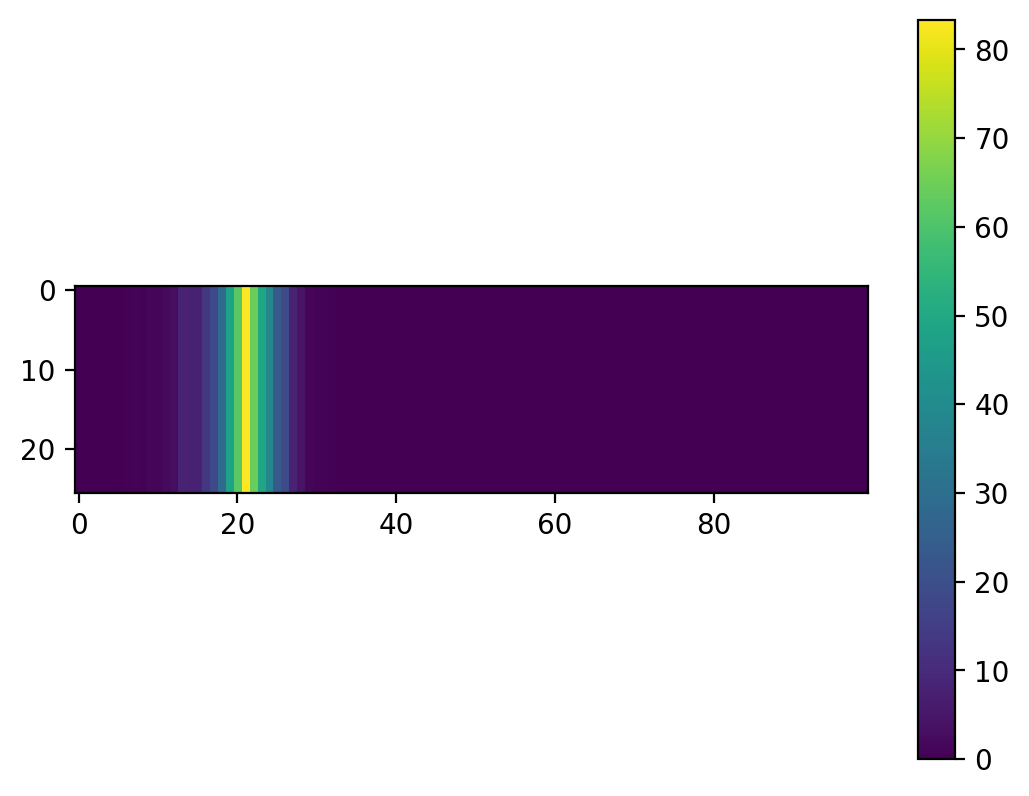

In [68]:
pl.imshow(norm);pl.colorbar()#.shape
pl.show()

In [31]:
def expand_parameters(cfg):
    '''This reads the nbin value and create so many iterations of the parameters'''

    cpars=cfg['Parameters']
    parlist=list(cpars.keys())
    for pp,par in enumerate(parlist):
        if('numpar' not in cpars[par].keys()):
            continue
        #if numpar is given then  change the parameters accordingly
        for ii in range(0,cpars[par]['numpar']):
            tpar='%s_%d'%(par,ii)
            cfg['Parameters'][tpar]=cfg['Parameters'][par].copy()
            for tt,tkey in enumerate(cfg['Parameters'][par].keys()):
                if(tkey=='numpar'):
                    cfg['Parameters'][tpar].pop(tkey)
                elif(isinstance(cfg['Parameters'][par][tkey],list) or 
                     isinstance(cfg['Parameters'][par][tkey],np.ndarray)):
                    cfg['Parameters'][tpar][tkey]=cfg['Parameters'][par][tkey][ii]
                    
        #pop the original parameter
        cfg['Parameters'].pop(par)

    
    return cfg

cfg=mcutil.init_config_yaml(inifile=config_file)
cfg=expand_parameters(cfg)

*****Using parameters *****
bz1
bz2
**** ndim= 2 ****
Setting: save_model = False
Setting: bfit = False
Setting: nthreads = 8


In [32]:
cfg['Parameters']

{'bz1': {'default': 3.24,
  'fixed': False,
  'prior': {'type': 'uniform', 'min': -5.0, 'max': 5.0}},
 'bz2': {'default': -1.87,
  'fixed': False,
  'prior': {'type': 'uniform', 'min': -5, 'max': 5}},
 'bz0_0': {'default': 0.53,
  'fixed': False,
  'prior': {'type': 'uniform', 'min': -5.0, 'max': 5.0}},
 'bz0_1': {'default': 0,
  'fixed': True,
  'prior': {'type': 'uniform', 'min': -5.0, 'max': 5.0}},
 'bz0_2': {'default': -1,
  'fixed': True,
  'prior': {'type': 'uniform', 'min': -5.0, 'max': 5.0}},
 'bz0_3': {'default': 0,
  'fixed': True,
  'prior': {'type': 'uniform', 'min': -5.0, 'max': 5.0}}}

In [10]:
cfg.keys()

dict_keys(['Cinterpolation', 'verbose', 'Likelihood', 'Sampler', 'Theory', 'initialize', 'tracer', 'sky', 'wsys', 'NNmodel_dir', 'data_dir', 'nzbin', 'NNtomoversion', 'fit_theta_lim', 'biasmodel', 'ellmax', 'chain_dir', 'outroot', 'Parameters', 'parlist', 'save_model', 'bfit', 'nthreads', 'redundant_Like', 'LD', 'use_zbin'])